In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root="data/Planetoid", name="Cora", transform=NormalizeFeatures())

print()
print(f"Dataset:                  {dataset}:")
print(
    "========================================================================================================"
)
print(f"Number of graphs:         {len(dataset)}")
print(f"Number of features:       {dataset.num_features}")
print(f"Number of classes:        {dataset.num_classes}")

data = dataset[0]

print(
    "========================================================================================================"
)
print(f"Number of nodes:          {data.num_nodes}")
print(f"Number of edges:          {data.num_edges}")
print(f"Average node degree:      {data.num_edges / data.num_nodes:.2f}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}")
print(f"Has isolated nodes:       {data.has_isolated_nodes()}")
print(f"Has self-loops:           {data.has_self_loops()}")
print(f"Is undirected:            {data.is_undirected()}")


Dataset:                  Cora():
Number of graphs:         1
Number of features:       1433
Number of classes:        7
Number of nodes:          2708
Number of edges:          10556
Average node degree:      3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes:       False
Has self-loops:           False
Is undirected:            True


# Finding cliques

1. Load the data in our own representation and get all 3-cliques from the graph

In [2]:
from graph import Graph, Node

graph = Graph(data)

2. Sort the cliques by given criteria. Currently it is sum of distances between all pairs of feature vectors: $\left| f_a - f_b \right| + \left| f_a - f_c \right| + \left| f_b - f_c \right|$ where $f_v$ is a feature vector of node $v$.

In [3]:
from numpy.linalg import norm
from typing import Tuple
from torch import Tensor


def euclidean_distance(tup: Tuple[Node, Node, Node]) -> float:
    a, b, c = tup

    ab_len = norm(a.features - b.features)
    ac_len = norm(a.features - c.features)
    bc_len = norm(b.features - c.features)

    return ab_len + ac_len + bc_len


def manhattan_distance(tup: Tuple[Node, Node, Node]) -> float:
    def _manhattan(a_feat: Tensor, b_feat: Tensor) -> float:
        return sum(abs(a_feat - b_feat))

    a, b, c = tup

    ab_len = _manhattan(a.features, b.features)
    ac_len = _manhattan(a.features, c.features)
    bc_len = _manhattan(b.features, c.features)

    return ab_len + ac_len + bc_len

3. When the cliques are sorted, we want to do exactly one round of 3-clique-folding:
- Take the clique with the smallest sum of distances
- Take average ($\frac{1}{3} * \Sigma_{i = 0}^2\ f_i$) of their feature vectors, call it "common features"
- Take all edges coming to all of the nodes from clique: $E\prime = \left\{ (v_k, v_j) | v_k \in (v_a, v_b, v_c),\ \neg j \in (a, b, c) \right\}$
- Delete nodes $v_a$, $v_b$, $v_c$ and all of their edges from the graph
- Create a new node with common features and all of the edges from $E\prime$

In [4]:
# Get initial set of 3-cliques
cliques = graph.get_all_3cliques()
cliques.sort(key=euclidean_distance)

while len(cliques):
    # Merge each 3-clique
    while len(cliques):
        top = cliques.pop(0)
        graph.replace_3clique_with_node(top)

        cliques = list(
            filter(
                lambda cl: all([v not in cl for v in top]),
                cliques,
            )
        )

    # Get the new set of 3-cliques
    cliques = graph.get_all_3cliques()
    cliques.sort(key=euclidean_distance)

In [5]:
processed_data = graph.get_graph_data(data)

In [6]:
print("Default dataset:", data)
print("Processed dataset:", processed_data)
print()

nodes_removed_share = (data.num_nodes - processed_data.num_nodes) / data.num_nodes * 100
default_edges = len(data.edge_index[0])
processed_edges = len(processed_data.edge_index[0])
edges_removed_share = (default_edges - processed_edges) / default_edges * 100

print(f"Removed {round(nodes_removed_share, 2)}% of nodes")
print(f"Removed {round(edges_removed_share, 2)}% of edges")

Default dataset: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Processed dataset: Data(x=[1084, 1433], edge_index=[2, 656], y=[1084], train_mask=[1084], val_mask=[1084], test_mask=[1084])

Removed 59.97% of nodes
Removed 93.79% of edges


Now let us create 2 models: first one with default dataset, and the second one with preprocessed data where 3-cliques were merged in one node

In [7]:
from model_tester import ModelTester
from GCNConv import GCNConvModel


default = GCNConvModel(
    data, num_features=dataset.num_features, num_classes=dataset.num_classes
)
default.name = "default"
cliques_merged = GCNConvModel(
    processed_data, num_features=dataset.num_features, num_classes=dataset.num_classes
)
cliques_merged.name = "processed"

default_tester = ModelTester(model=default)
preprocessed_tester = ModelTester(model=cliques_merged)

In [8]:
default_test_results = default_tester.train(300)
default_test_results

Model:                  default
Tests ran:              1
Average training time:  2.467s
Average accuracy:       0.806
Average final loss:     0.25983
Average entropy:        0.57388

In [9]:
preprocessed_test_results = preprocessed_tester.train(300)
preprocessed_test_results

Model:                  processed
Tests ran:              1
Average training time:  1.082s
Average accuracy:       0.49361
Average final loss:     0.35917
Average entropy:        0.77541

# Benchmark

Now, in order to calculate average accuracy, we ought to run $N$ iterations of `train_and_test` with $M$ epochs

In [10]:
N = 100
M = 300

In [11]:
default_bulk_results = default_tester.bulk_train(steps=N, epochs=M)
default_bulk_results

  0%|          | 0/100 [00:00<?, ?it/s]

Model:                  default
Tests ran:              100
Average training time:  2.443s
Average accuracy:       0.80732
Average final loss:     0.26216
Average entropy:        0.57179

In [12]:
preprocessed_bulk_results = preprocessed_tester.bulk_train(steps=N, epochs=M)
preprocessed_bulk_results

  0%|          | 0/100 [00:00<?, ?it/s]

Model:                  processed
Tests ran:              100
Average training time:  1.037s
Average accuracy:       0.5066
Average final loss:     0.29244
Average entropy:        0.76914

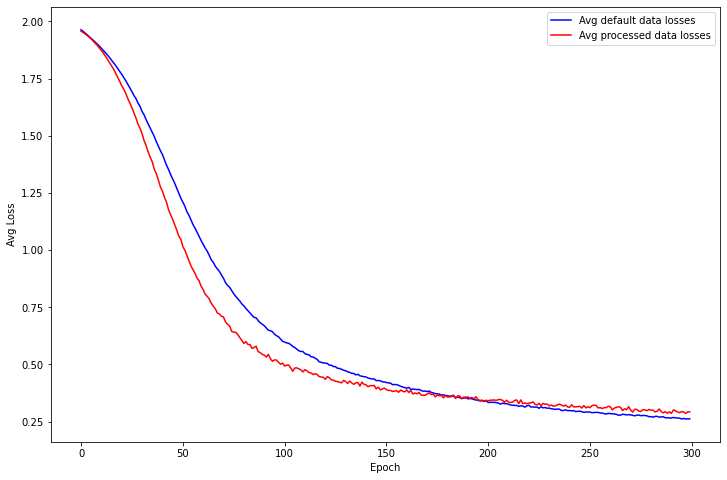

In [13]:
import matplotlib.pyplot as plt

default_avg_losses = sum(default_bulk_results.losses) / len(default_bulk_results.losses)
merged_avg_losses = sum(preprocessed_bulk_results.losses) / len(
    preprocessed_bulk_results.losses
)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(default_avg_losses, color="blue", label="Avg default data losses")
ax.plot(merged_avg_losses, color="red", label="Avg processed data losses")

plt.xlabel("Epoch")
plt.ylabel("Avg Loss")

least_y = min(min(default_avg_losses), min(merged_avg_losses))
greatest_y = max(max(default_avg_losses), max(merged_avg_losses))

plt.ylim(
    (least_y - 0.1, greatest_y + 0.1)
)  # we add/subtract 0.1 in order to make the plot look nicer
plt.legend()
plt.show()

This graph clearly shows us that preprocessing allows us to reduce loss, and, therefore, achieve same results faster. But what about accuracy?

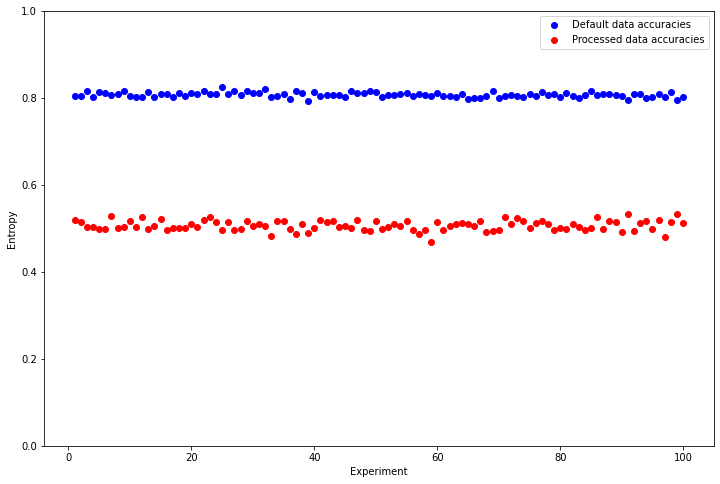

In [14]:
import numpy as np

fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(1, 1 + N)

ax.scatter(
    x=x,
    y=default_bulk_results.accuracies,
    color="blue",
    label="Default data accuracies",
)
ax.scatter(
    x=x,
    y=preprocessed_bulk_results.accuracies,
    color="red",
    label="Processed data accuracies",
)

plt.xlabel("Experiment")
plt.ylabel("Entropy")

plt.ylim((0, 1))

plt.legend()
plt.show()

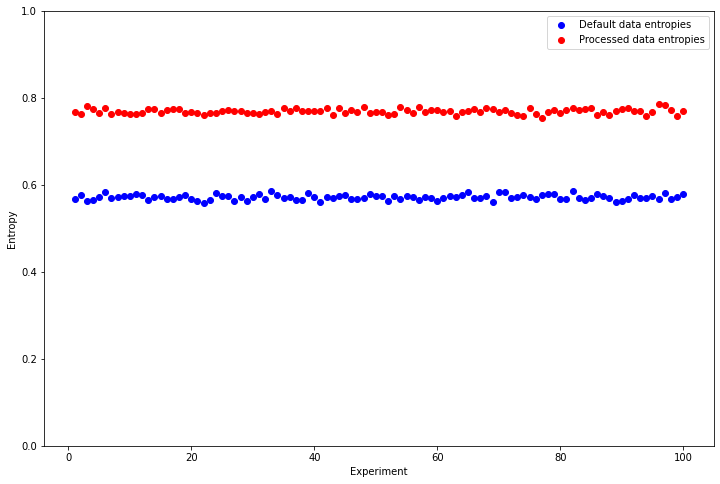

In [15]:
import numpy as np

fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(1, 1 + N)

ax.scatter(
    x=x,
    y=default_bulk_results.entropies,
    color="blue",
    label="Default data entropies",
)
ax.scatter(
    x=x,
    y=preprocessed_bulk_results.entropies,
    color="red",
    label="Processed data entropies",
)

plt.xlabel("Experiment")
plt.ylabel("Entropy")

plt.ylim((0, 1))

plt.legend()
plt.show()

In [16]:
default_bulk_results.avg_accuracy - preprocessed_bulk_results.avg_accuracy

0.30072153452685446